In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='..\Datasets\FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='..Datasets\FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# 小批量读取数据
batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers=0)

In [4]:
# 实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
        

In [5]:
# 模型定义和参数初始化
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
)
mParameters = net.parameters()

for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    

mParameters <generator object Module.parameters at 0x000001A5D5F74200>
0
torch.Size([256, 784])
1
torch.Size([256])
2
torch.Size([10, 256])
3
torch.Size([10])


In [6]:
# 计算准确率和loss
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
        return acc_sum / n, test_l_sum / n

In [7]:
# 设置训练轮次，学习率，损失函数
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()

# 使用weight_decay实现L2范数正则化
wd = 0.01 
optimizer =torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
# optimizer_w =torch.optim.SGD(params=[net.parameters.weight], lr = lr, weight_decay=wd)
# optimizer_b =torch.optim.SGD(params=[net.bias], lr = lr)

In [8]:
# 模型训练
def train(net, mnist_train, mnist_test, loss, num_epochs, batch_size, params=None, lr = None, optimizer_w=None, optimizer_b=None):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_l_sum / n, test_l))    
    return train_loss, test_loss

epoch 1, train_loss 0.0225, test_loss 0.0143
epoch 2, train_loss 0.0124, test_loss 0.0127
epoch 3, train_loss 0.0106, test_loss 0.0114
epoch 4, train_loss 0.0096, test_loss 0.0108
epoch 5, train_loss 0.0090, test_loss 0.0103
epoch 6, train_loss 0.0086, test_loss 0.0103
epoch 7, train_loss 0.0084, test_loss 0.0095
epoch 8, train_loss 0.0082, test_loss 0.0096
epoch 9, train_loss 0.0081, test_loss 0.0093
epoch 10, train_loss 0.0079, test_loss 0.0096


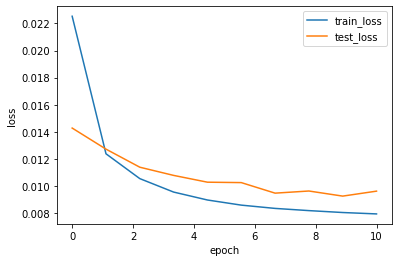

In [9]:
train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

# 画图
x = np.linspace(0, len(train_loss), len(train_loss))
plt.plot(x, train_loss, label = 'train_loss', linewidth=1.5)
plt.plot(x, test_loss, label='test_loss', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()